# **Dataset: Preprocessing, EDA, and Embedding**
Our task is to develop a model that predicts the price trend of a given stock (_increase_ or _decrease_). The idea is to simulate an environment where data is continually fed to the model, and that it will aggregate these into an output for each stock, determining whether the price will increase or decrease.

We will be using the Twitter dataset for this task. The dataset consists of tweets and the stock it directed at, along with the timestamp the tweet was created. Then, we will be cleaning text data so that it is in a more machine-friendly form. This notebook will go through each of the following sections:
1. **Data Preprocessing**:
    * Cleanup text and merge the Twitter dataset with the Stock Price dataset. In this section, we will also be constructing our own label to fit with the task at hand.
    * Perform Train/Validate/Test split, and then do further EDA to ensure the splits are well-defined.
2. **Exploratory Data Analysis**: Perform EDA on the combined dataset as well as the dataset splits.
3. **Enhanced Dataset**: Create an enhanced dataset for models to use.

In [306]:
import pandas as pd
import kagglehub
import re
import ssl
import html
import emoji
import langdetect
import yfinance as yf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from torch.utils.data import Dataset

join_char = ' [SEP] '
time_interval = 'D'
external_stock = 'N/A'
stable_moe = 0.01
labels = {0: 'decrease', 1: 'increase'}

# 1. Data Preprocessing

### Twitter Dataset

In [2]:
twitter_path = kagglehub.dataset_download("equinxx/stock-tweets-for-sentiment-analysis-and-prediction")
reddit_path = kagglehub.dataset_download("suruchiarora/top-25-world-news-2018-2023")

print("Path to dataset files:", twitter_path)
print("Path to dataset files:", reddit_path)

Path to dataset files: C:\Users\thedu\.cache\kagglehub\datasets\equinxx\stock-tweets-for-sentiment-analysis-and-prediction\versions\1
Path to dataset files: C:\Users\thedu\.cache\kagglehub\datasets\suruchiarora\top-25-world-news-2018-2023\versions\1


### Aggregate all posts in the same interval by stock
In order to simulate the environment where data is continually fed to the model without having to model our problem in a direct time-series manner, we will be aggregating these inputs into a large text. Our approach here is to join the entries of same stock within the same time interval (e.g. day) by concatenating all such posts. These posts will be joined by a special character `' [SEP] '`, which is an often used separator in language models' vocabularies.

As for `N/A` stock (_external_ posts which are assumed to affect every stock), we must concatenate it with every stock that gets mentioned within that day. This is based on our stated asssumption, where external influences should be considered for all stocks. However, in this task, we will not be considering external influences for stocks that are not mentioned in the Twitter dataset within a specific time interval. This is because we do not have sufficient World News data, so this may increase volatility in the our results.

In [3]:
def group_by_interval_and_stock(
    df: pd.DataFrame, interval: str,
    join_char: str=' [SEP] ', stock: str|None='stock', day: str='trading_day', post: str='post'
):
    """
    Aggregate dataframe at hand by entries of the same time interval (e.g. day) and stock.
    Interval can be 'D', 'W', 'ME', 'Q', or 'Y'.
    """
    df[day] = pd.to_datetime(df[day])
    groupby = [pd.Grouper(key=day, freq=interval)]
    if not stock is None:
        groupby.append(stock)
    df_agg = df.groupby(groupby, as_index=False)[post].apply(lambda x: join_char.join(x))
    df_agg = df_agg.reset_index(drop=True)
    return df_agg


def get_trading_day(
    df: pd.DataFrame, date: str='date', day: str='trading_day', stock: str='stock'
) -> pd.DataFrame:
    # extract trading day (date without time) and sort within each day
    df[day] = pd.to_datetime(df[date]).dt.date
    df = df.sort_values([day, stock, date])
    return df


def restructure_dataset(
    df: pd.DataFrame, day: str='trading_day', stock: str='stock', label: str='label'
) -> pd.DataFrame:
    # ensure label is consistent for all tweets about the same stock on the same day
    # (since they all predict the same next day's movement)
    day_stock_label = df.groupby([day, stock])[label].first().reset_index()

    # merge to ensure consistent labels
    suffix = '_original'
    df = df.merge(day_stock_label, on=[day, stock], suffixes=(suffix, ''))
    df = df.drop(columns=[label + suffix])
    return df

### Text cleanup
Helper functions to clean up texts, which are texts that include HTML escaped characters, or non-ASCII characters. It will also include a helper function to detect whether a post is in English or not. This is to match with English compatibility requirement of the Twitter dataset.

In [4]:
# remove hashtag symbols, replace urls with [URL], remove repeated punctuation (ie !!! --> !),
# replace emoji with text version ie ' :warning: '
def clean_text(post):
    try:
        # decode HTML entities like '&amp;' to '&'
        post = html.unescape(post)
        # remove non-ASCII characters
        post = ''.join(char for char in post if ord(char) < 128)
        # remove hashtag, newline, and squared brackets, which are reserved for special characters
        post = post.replace('#', ' ')
        post = post.replace('\n', ' ')
        post = post.replace('[', ' ')
        post = post.replace(']', ' ')
        # replace URL with special URL character
        post = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '[URL]', post)
        # remove emojis and deal with bad repeated patterns (including repeated whitespaces)
        post = re.sub(r'\s+', ' ', post)
        repeated_pattern = re.compile(r'([^\w\s])\1+')
        post = repeated_pattern.sub(r'\1', post)
        post = emoji.demojize(post, delimiters = (" :", ": "))
        repeated_pattern = re.compile(r':+')
        post = repeated_pattern.sub(':', post)
        return post
    except:
        return ''

def is_english(post):
    if post == '':
        return False
    try:
        # remove non-alphanumeric characters to check if text is english
        post = re.sub(r'[^\w\s,]', '', post)
        return langdetect.detect(post) == 'en'
    except:
        return False

## 1.1. Twitter Stock Tweets Dataset

In [5]:
stock_tweets_path = twitter_path + '\\stock_tweets.csv'
stock_tweets_df = pd.read_csv(stock_tweets_path)

#### Text Cleanup

In [6]:
# clean up posts
stock_tweets_df['cleaned'] = stock_tweets_df['Tweet'].apply(clean_text)
stock_tweets_df = stock_tweets_df.drop(columns=['Tweet', 'Company Name'])
stock_tweets_df = stock_tweets_df.rename(columns={
    'cleaned': 'post', 'Date': 'date', 'Stock Name': 'stock',
})
stock_tweets_df = stock_tweets_df.dropna().loc[stock_tweets_df['post'].str.strip().ne('')]

# datetime conversion
stock_tweets_df['date'] = pd.to_datetime(stock_tweets_df['date'])
stock_tweets_df = stock_tweets_df.sort_values(by='date')
stock_tweets_df = get_trading_day(stock_tweets_df)

#### Removing Duplicates

In [7]:
duplicates = stock_tweets_df[stock_tweets_df.duplicated(keep=False)]
stock_tweets_df = stock_tweets_df.drop_duplicates()
duplicates = stock_tweets_df[stock_tweets_df.duplicated(keep=False)]
assert len(duplicates) == 0

## 1.2. Stock Price Dataset

In [8]:
stock_finance_path = twitter_path + '\\stock_yfinance_data.csv'
stock_finance_df = pd.read_csv(stock_finance_path)

#### Cleanup
We will only be using the **Adjusted Close** price rather than the actual Close price. This is because while close price can provide a snapshot of the stock price at the end of the day, adjusted close price provides a cleaner view for performance analysis over time, especially when comparing historical returns. This is particularly important for long-term investors or understanding trends in a stock price.

In [9]:
stock_finance_df = stock_finance_df.rename(columns={
    'Adj Close': 'adj_close', 'Stock Name': 'stock'
})
stock_finance_df.columns = stock_finance_df.columns.str.lower()
stock_finance_df['trading_day'] = pd.to_datetime(stock_finance_df['date']).dt.date
stock_finance_df = stock_finance_df.drop(columns=['volume', 'high', 'low', 'close', 'date'])
stock_finance_df = stock_finance_df.dropna()
stock_finance_df

,open,adj_close,stock,trading_day
0,260.333344,258.493347,TSLA,2021-09-30
1,259.466675,258.406677,TSLA,2021-10-01
2,265.500000,260.510010,TSLA,2021-10-04
3,261.600006,260.196655,TSLA,2021-10-05
4,258.733337,260.916656,TSLA,2021-10-06
...,...,...,...,...
6295,13.090000,13.710000,XPEV,2022-09-23
6296,14.280000,14.370000,XPEV,2022-09-26
6297,14.580000,13.710000,XPEV,2022-09-27
6298,13.050000,13.330000,XPEV,2022-09-28


#### Label Classification
To determine if the stock price goes up or down within a specified time interval is a trivial task - we simply take the difference and see if it is greater or less than 0. However, this could be highly volatile as a result. Instead, we will also consider a **Stable** class, where as long as the difference is within a margin of error, then it considered stable.

Ideally, we would determine this margin of error for each stock. However, we will be making an **assumption** that stock prices are generally similarly volatile, and we will be using a safe threshold of **1%** of the Open price.

With this, we will have 3 labels: **Increase** (`1`), **Decrease** (`-1`), and **Stabilize** (`0`).

In [10]:
# corresponds to buy, sell, and do nothing
INCREASE = 1
DECREASE = 0

# stock price difference and margin of error
stock_finance_df['diff'] = stock_finance_df['adj_close'] - stock_finance_df['open']
stock_finance_df['moe'] = stock_finance_df['open'] * 0.0

# classifying stock
classification_conditions = [
    (stock_finance_df['diff'] <= 0)
]

values = [DECREASE]
stock_finance_df['label'] = np.select(classification_conditions, values, default=INCREASE)

# drop irrelevant columns
stock_finance_df = stock_finance_df.drop(columns=['adj_close', 'open', 'diff', 'moe'])
stock_finance_df

,stock,trading_day,label
0,TSLA,2021-09-30,0
1,TSLA,2021-10-01,0
2,TSLA,2021-10-04,0
3,TSLA,2021-10-05,0
4,TSLA,2021-10-06,1
...,...,...,...
6295,XPEV,2022-09-23,1
6296,XPEV,2022-09-26,1
6297,XPEV,2022-09-27,0
6298,XPEV,2022-09-28,1


## 1.3. Combined Dataset

### 1.3.1. Merge Twitter Dataset with Stock Trend Dataset
First we do a simple left merge on all posts. Then we must fill out wherever the label is Null. This happens when stock data for a specific date does not exist in the provided dataset.

In [11]:
# aggregate stock tweets dataframe
df_all_posts = group_by_interval_and_stock(stock_tweets_df, time_interval, join_char)
df_all_posts['trading_day'] = pd.to_datetime(df_all_posts['trading_day']).dt.date

df = pd.merge(df_all_posts, stock_finance_df, on=['trading_day', 'stock'], how='left')
df

,trading_day,stock,post,label
0,2021-09-30,AAPL,I bought my first $AAPL stock in 2010. Since t...,0.0
1,2021-09-30,AMD,AMD Expands Collaboration With Google Cloud to...,1.0
2,2021-09-30,AMZN,Shopify is now 9% of US e-commerce. It really ...,0.0
3,2021-09-30,DIS,$DIS Read I'm saying this mf is READY and I'm ...,0.0
4,2021-09-30,GOOG,Thanks goog [URL],0.0
...,...,...,...,...
5905,2022-09-29,PG,9/29/22 Options Trading Watchlist $AMZN 114/11...,0.0
5906,2022-09-29,PYPL,High quality businesses such as $ADBE $GOOGL $...,0.0
5907,2022-09-29,TSLA,What would I do as a new trader to become succ...,0.0
5908,2022-09-29,TSM,Feels so fucking good to see myself actually g...,0.0


### 1.3.1. Handling `null` Entries
Since we merge the stock finance data with the Twitter dataset (right join, retaining the Twitter data), that means if there exists any `null` (invalid) entries, then the label for said stock at said day does not exist. In other words, there is missing stock data on that day. As we have found out through crawling, the stock data cannot be found for these specific days. So we decided to simply remove `null` entries.

In [15]:
df = df.dropna()
df['label'] = df['label'].astype(int)
df

,trading_day,stock,post,label
0,2021-09-30,AAPL,I bought my first $AAPL stock in 2010. Since t...,0
1,2021-09-30,AMD,AMD Expands Collaboration With Google Cloud to...,1
2,2021-09-30,AMZN,Shopify is now 9% of US e-commerce. It really ...,0
3,2021-09-30,DIS,$DIS Read I'm saying this mf is READY and I'm ...,0
4,2021-09-30,GOOG,Thanks goog [URL],0
...,...,...,...,...
5905,2022-09-29,PG,9/29/22 Options Trading Watchlist $AMZN 114/11...,0
5906,2022-09-29,PYPL,High quality businesses such as $ADBE $GOOGL $...,0
5907,2022-09-29,TSLA,What would I do as a new trader to become succ...,0
5908,2022-09-29,TSM,Feels so fucking good to see myself actually g...,0


In [12]:
# since we merge stock finance data by all posts, if there exists any Null invalid entries,
# it must mean that the label for said stock at said day does not exist
null_labels_df = df[df.isna().any(axis=1)]

# ensuring no null post/tweet
assert any(list(null_labels_df[['post']].isna().any(axis=1))) == False
null_labels_df

,trading_day,stock,post,label
28,2021-10-02,AAPL,Woah. $AAPL is currently 84% bullish on the da...,NaN
29,2021-10-02,AMD,Current holdings since ppl asked: $gogo $ntnx ...,NaN
30,2021-10-02,AMZN,Holy Jeff Bezos! $AMZN is 90% bullish on the d...,NaN
31,2021-10-02,CRM,Portfolio Update: been a while but about ~175%...,NaN
32,2021-10-02,DIS,Weekend video out! One of my favorite videos f...,NaN
...,...,...,...,...
5839,2022-09-25,PG,Posted options flow data for $SPY $QQQ $IWM Mo...,NaN
5840,2022-09-25,PYPL,Year-to-Date Performance: 1. $FB: -59% 2. $AAP...,NaN
5841,2022-09-25,TSLA,"When I drive on FSD Beta, I know Tesla full se...",NaN
5842,2022-09-25,TSM,HAPPY BIRTHDAY @TSM_Pojoman A World Champion a...,NaN


In [143]:
# check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
trading_day    0
stock          0
post           0
label          0
dtype: int64


## 1.4. Dataset Split
In this section, we will be splitting the dataset into Train, Validate, and Test splits. We will be splitting based as a time-series dataset: we essentially split the dataset by day (our interested unit of time).

The split is **0.7 - 0.15 - 0.15**. Meaning the training dataset will be the first 70% of the days, the validate set will be the next 15%, and the test set will be the final 15%.

In [160]:
def create_dataset_split(
    df: pd.DataFrame, train_size: float=0.7, val_size: float=0.15, day: str='trading_day'
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    df[day] = pd.to_datetime(df[day])
    df = df.sort_values(day)
    unique_days = df[day].unique()
    train_idx = int(len(unique_days) * train_size)
    val_idx = int(len(unique_days) * (train_size + val_size))
    train_cutoff = unique_days[train_idx]
    val_cutoff = unique_days[val_idx]

    train_df = df[df[day] <= train_cutoff]
    val_df = df[(df[day] > train_cutoff) & (df[day] <= val_cutoff)]
    test_df = df[df[day] > val_cutoff]
    return train_df, val_df, test_df

In [161]:
train_df, val_df, test_df = create_dataset_split(df)

# 2. Exploratory Data Analysis
The following is the basic Exploratory Data Analysis processes to ensure the validity, integrity, and usability of the dataset in question.
1. Stock Distribution Analysis
2. Label Distribution Analysis
3. Combined Dataset Discussions

#### Plot Helpers

In [299]:
def plot_dist(df, title, ax, x_col, notable_x, notable_xl, font_factor=1.0):
    xs = sorted(list(df[x_col].unique()))
    xs_counts = [len(df[df[x_col] == x]) for x in xs]
    bars = ax.bar(xs, xs_counts)
    if x_col == 'stock':
        highlight_xs = notable_x + [i - len(xs) if i > 0 else i + len(xs) for i in notable_x]
        highlight_xs.extend([i for i, x in enumerate(xs) if x in notable_xl])
        for x in highlight_xs:
            bars[x].set_color('red')
        ax.set_xticks([x if i in highlight_xs else '' for i, x in enumerate(xs)])
    else:
        ax.set_xticks(xs)
    ax.set_title(title, size=font_factor*19)
    ax.tick_params(axis='both', which='major', labelsize=10*font_factor)


def plot_multiple_distributions(
    df, title, labels, x_label, y_label, cols=5, stock='stock', day='trading_day', post='post', label='label',
    x_axis_factor=0.0, y_axis_factor=1.0, font_factor=1.0, sharey=True,
):
    # get stocks and counts
    label_keys = list(labels.keys())
    stocks = df[stock].unique()
    stock_count = {}
    for s in stocks:
        s_df = df[df[stock] == s]
        l0 = len(s_df[s_df[label] == 0])
        stock_count[s] = [l0, len(s_df) - l0]

    # row, column, and factoring
    total = len(stocks)
    rows  = total//cols + 1 if total > cols else 1
    if x_axis_factor <= 0:
        x_axis_factor = 1

    # figure and axis
    fig, ax = plt.subplots(
        rows, cols, figsize=(26*x_axis_factor, 26*y_axis_factor), sharey=sharey
    )
    fig.suptitle(title, fontsize=25*font_factor, y=0.93)
    fig.text(0.5, 0.21, x_label, ha='center', fontsize=15*font_factor)
    fig.text(0.08, 0.5, y_label, va='center', rotation='vertical', fontsize=15*font_factor)

    # legend
    legend_labels  = [f'{i}: {labels[i]}' for i in range(len(labels))]
    legend_handles = [plt.Rectangle((0,0), 0, 0, alpha=0.0) for _ in labels]
    fig.legend(
        legend_handles, legend_labels, prop={'size': 15}, bbox_to_anchor=(0.9, 0.93)
    )

    # distribution for each folder
    for i in range(cols*rows):
        ax_i = ax[i] if rows == 1 else ax[i//cols, i%cols]
        if i >= total:
            ax_i.axis('off')
            continue # leave blank rather than stop
        ax_i.set_title(stocks[i], fontsize=17*font_factor)
        ax_i.bar(label_keys, stock_count[stocks[i]], tick_label=[f'{i}' for i in label_keys])


def plot_multiple_dfs(
    dfs, title, subtitles, labels, x_label, y_label, x_col, cols=3, notable_x=[], notable_xl=[], stock='stock',
    day='trading_day', post='post', label='label', x_axis_factor=0.0, y_axis_factor=1.0, font_factor=1.0, sharey=True,
):
    # row, column, and factoring
    total = len(dfs)
    rows  = total//cols + 1 if total > cols else 1
    if x_axis_factor <= 0:
        x_axis_factor = 1

    # figure and axis
    fig, ax = plt.subplots(
        rows, cols, figsize=(28*x_axis_factor, 7*y_axis_factor), sharey=sharey
    )
    fig.suptitle(title, fontsize=25*font_factor, y=1)
    fig.text(0.5, 0.05, x_label, ha='center', fontsize=15)
    fig.text(0.1, 0.5, y_label, va='center', rotation='vertical', fontsize=15)

    # distribution for each folder
    for i in range(cols*rows):
        ax_i = ax[i] if rows == 1 else ax[i//cols, i%cols]
        if i >= total:
            ax_i.axis('off')
            continue # leave blank rather than stop
        plot_dist(
            dfs[i], subtitles[i], ax_i, x_col, font_factor=font_factor, notable_x=notable_x, notable_xl=notable_xl
        )


def plot_multiple_dfs_and_distributions(
    dfs, title, subtitles, labels, x_label, y_label, cols=3, notable_x=[], notable_xl=[], stock='stock',
    day='trading_day', post='post', label='label', x_axis_factor=0.0, y_axis_factor=1.0, font_factor=1.0, sharey=True,
):
    # get stocks and counts
    label_keys = list(labels.keys())
    stocks = dfs[0][stock].unique()
    stock_counts = []
    for df in dfs:
        stock_count = {}
        for s in stocks:
            s_df = df[df[stock] == s]
            l0 = len(s_df[s_df[label] == 0])
            stock_count[s] = [l0, len(s_df) - l0]
        stock_counts.append(stock_count)

    # row, column, and factoring
    total = len(stocks)
    rows  = total//cols + 1 if total > cols else 1
    if x_axis_factor <= 0:
        x_axis_factor = 1

    # figure and axis
    fig, ax = plt.subplots(
        rows, cols, figsize=(26*x_axis_factor, 26*y_axis_factor), sharey=sharey
    )
    fig.suptitle(title, fontsize=25*font_factor, y=0.93)
    fig.text(0.5, 0.21, x_label, ha='center', fontsize=15*font_factor)
    fig.text(0.08, 0.5, y_label, va='center', rotation='vertical', fontsize=15*font_factor)

    # # legend
    # legend_labels  = [f'{i}: {labels[i]}' for i in range(len(labels))]
    # legend_handles = [plt.Rectangle((0,0), 0, 0, alpha=0.0) for _ in labels]
    # fig.legend(
    #     legend_handles, legend_labels, prop={'size': 15}, bbox_to_anchor=(0.9, 0.93)
    # )

    # distribution for each folder
    for i in range(cols*rows):
        ax_i = ax[i] if rows == 1 else ax[i//cols, i%cols]
        if i >= total:
            ax_i.axis('off')
            continue
        ax_i.set_title(stocks[i], fontsize=17*font_factor)
        ax_i.bar(label_keys, stock_count[stocks[i]], tick_label=[f'{i}' for i in label_keys])

## 2.1. Stock Distribution Analysis
This section will be looking at the stock distribution of each stock in the entire dataset, as well as for each data split.

### 2.1.1. Entire Dataset

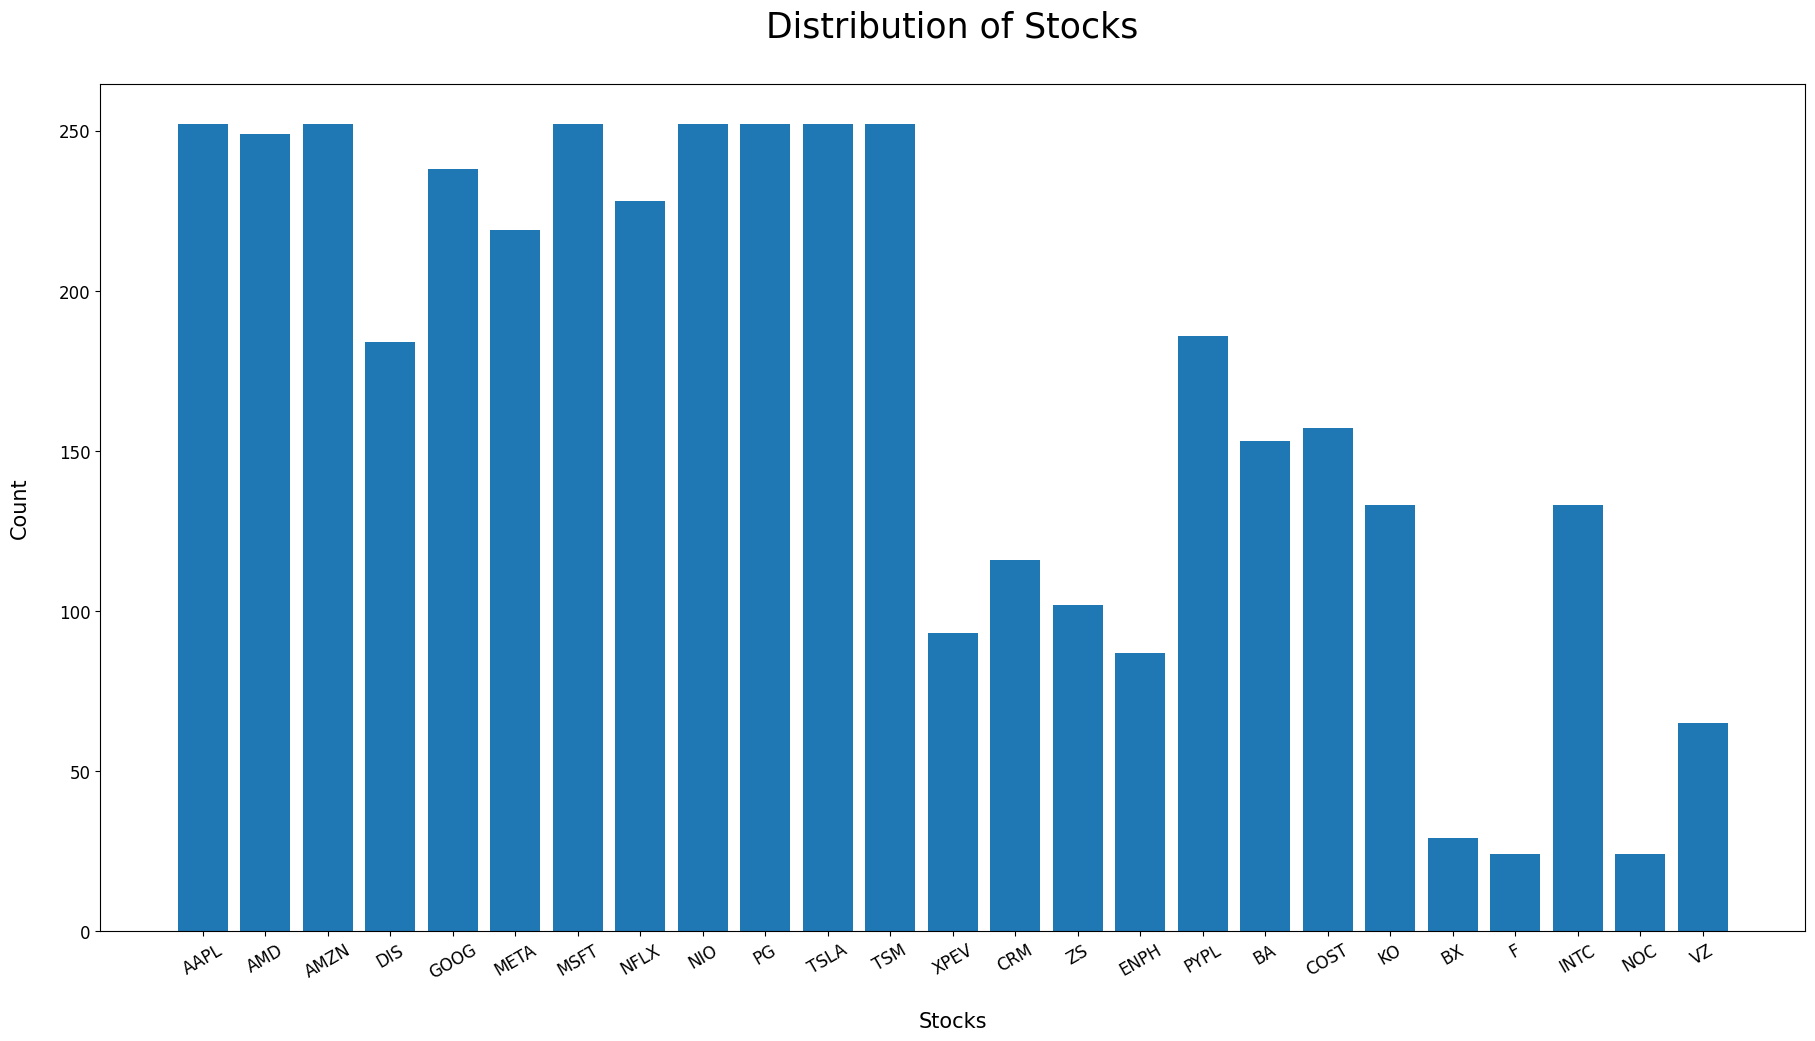

In [141]:
def plot_stock_dist(
    df: pd.DataFrame, title: str,
    stock: str|None='stock', day: str='trading_day', post: str='post', label: str='label'
):
    stocks = list(df[stock].unique())
    stock_counts = [len(df[df[stock] == s]) for s in stocks]
    plt.figure(figsize=(22, 11))
    plt.bar(stocks, stock_counts)
    plt.title(title + '\n', size=25)
    plt.xlabel('\nStocks', size=15)
    plt.ylabel('Count\n', size=15)
    plt.xticks(rotation=30, size=12)
    plt.yticks(size=12)
    plt.show()

plot_stock_dist(df, 'Distribution of Stocks')

From this plot, we can see that there is an imbalance in stock distribution. We will not be using techniques that directly manipulate the dataset such as Oversampling (which is usually not ideal for time-series data) or re-sampling with respect to time. This is because we expect that, in reality, the model would have to deal with new stocks being introduced on-the-fly. And in cases such as these, the model will have to be able to infer its price trends based on more limited data, compared to popular stocks such as AAPL.

And for that reason, we will address this issue within the model itself, with methods such as Focal Loss. This will help ensure that the model will be more useful on-the-fly, and not just limited to the stocks available within the dataset.

### 2.1.2. Dataset Split
Generally, we can see that the stocks between datasets are relatively similarly distributed, with the exception of ENPH (highlighted red) which has noticeable distribution differences across splits. This will be taken into consideration when evaluating model performances, especially qualitatively for each stock.

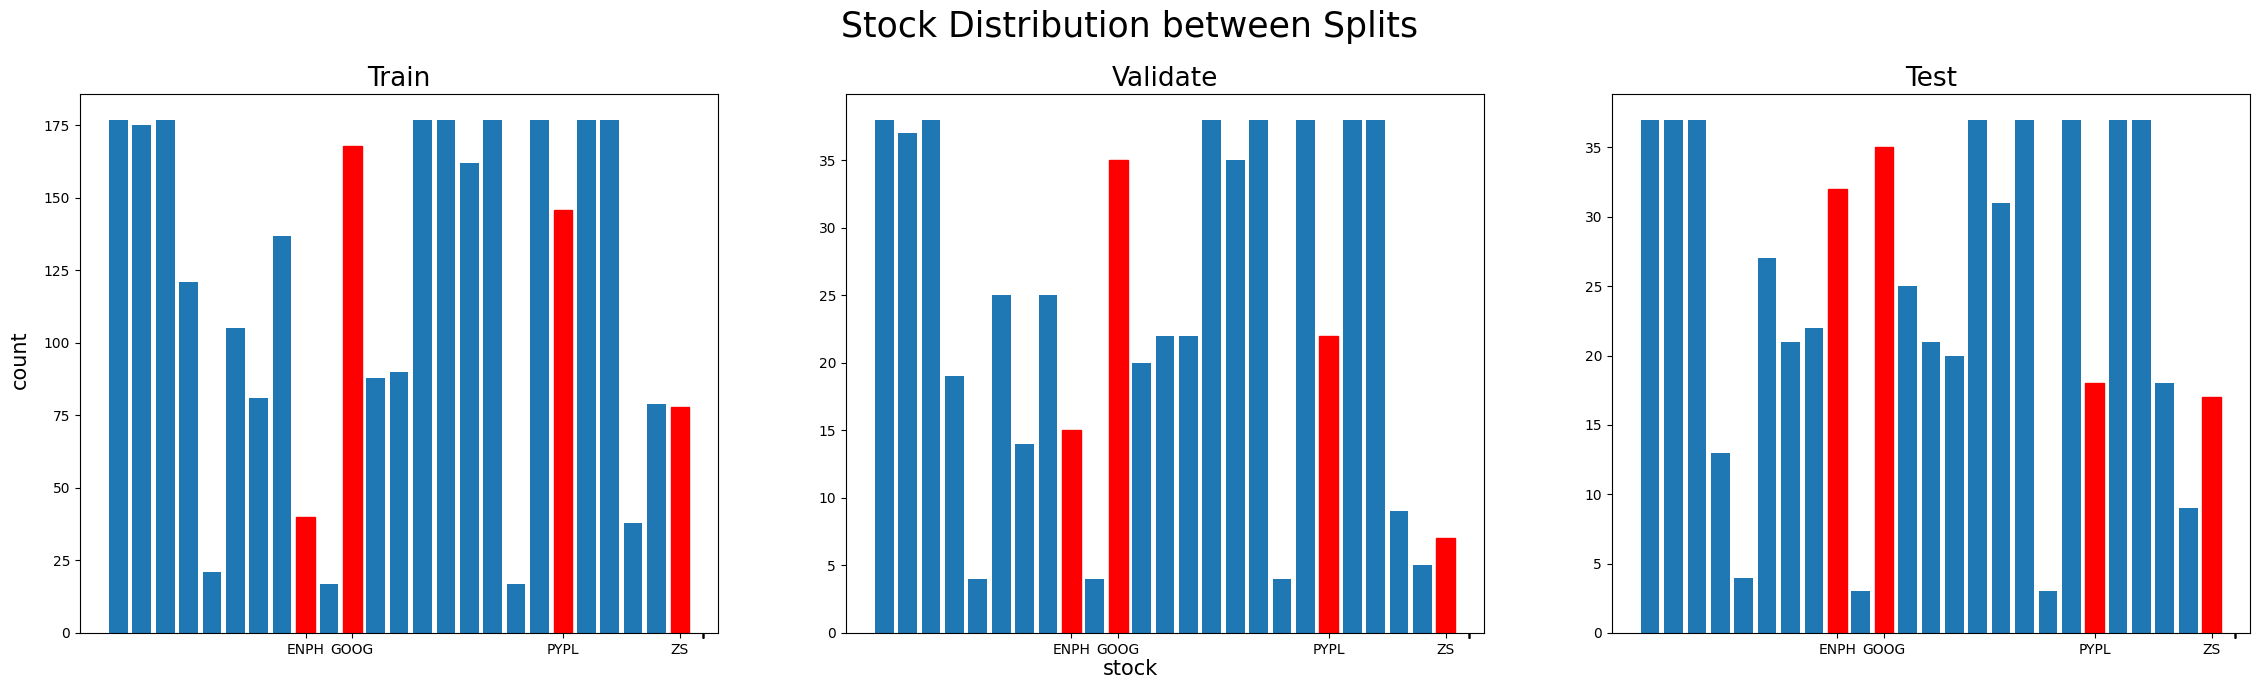

In [300]:
plot_multiple_dfs(
    [train_df, val_df, test_df], 'Stock Distribution between Splits', ['Train', 'Validate', 'Test'], labels,
    x_col='stock', x_label='stock', y_label='count', notable_x=[8], notable_xl=['PYPL', 'ZS', 'GOOG'], sharey=False
)

## 2.2. Label Distribution Analysis
This section will be looking at the label distribution of the entire dataset, and for each dataset split. In each of these subsections, it will look at the label distribution of all stocks versus that of each individual stock.

### 2.2.1. Entire Dataset

#### **All Stocks**
We can see below that the labels are fairly well-distributed with no serious imbalance issue.

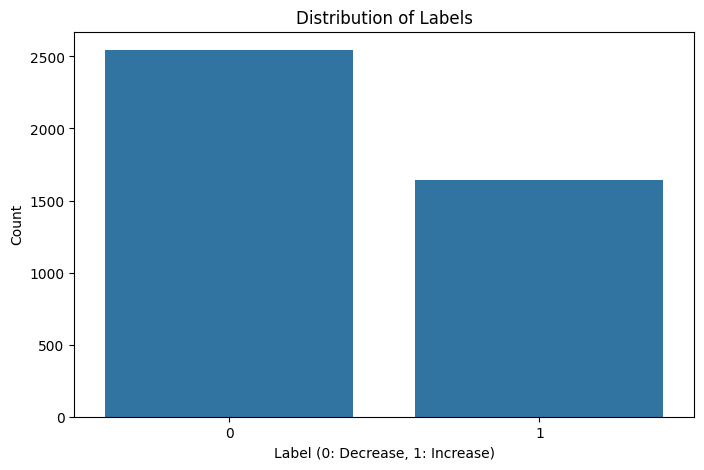

In [19]:
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df)
plt.title('Distribution of Labels')
plt.xlabel('Label (0: Decrease, 1: Increase)')
plt.ylabel('Count')
plt.show()

#### **For each stock**
From the plot below, we can see that stocks generally have balanced label distribution. However, some notable exceptions include PG, KO, BX, INTC, and VZ, all with overwhelming downward stock price trend. In particular, it seems that VZ does not have any _Increase_ data point.

We will take this into consideration when looking at the dataset split distributions. That is, if the distribution largely differs between these sets (for example, if most of the downward trend occurs during the training set, whereas in the future for the test set only does the upward trend appear), then the models will struggle with these patterns.

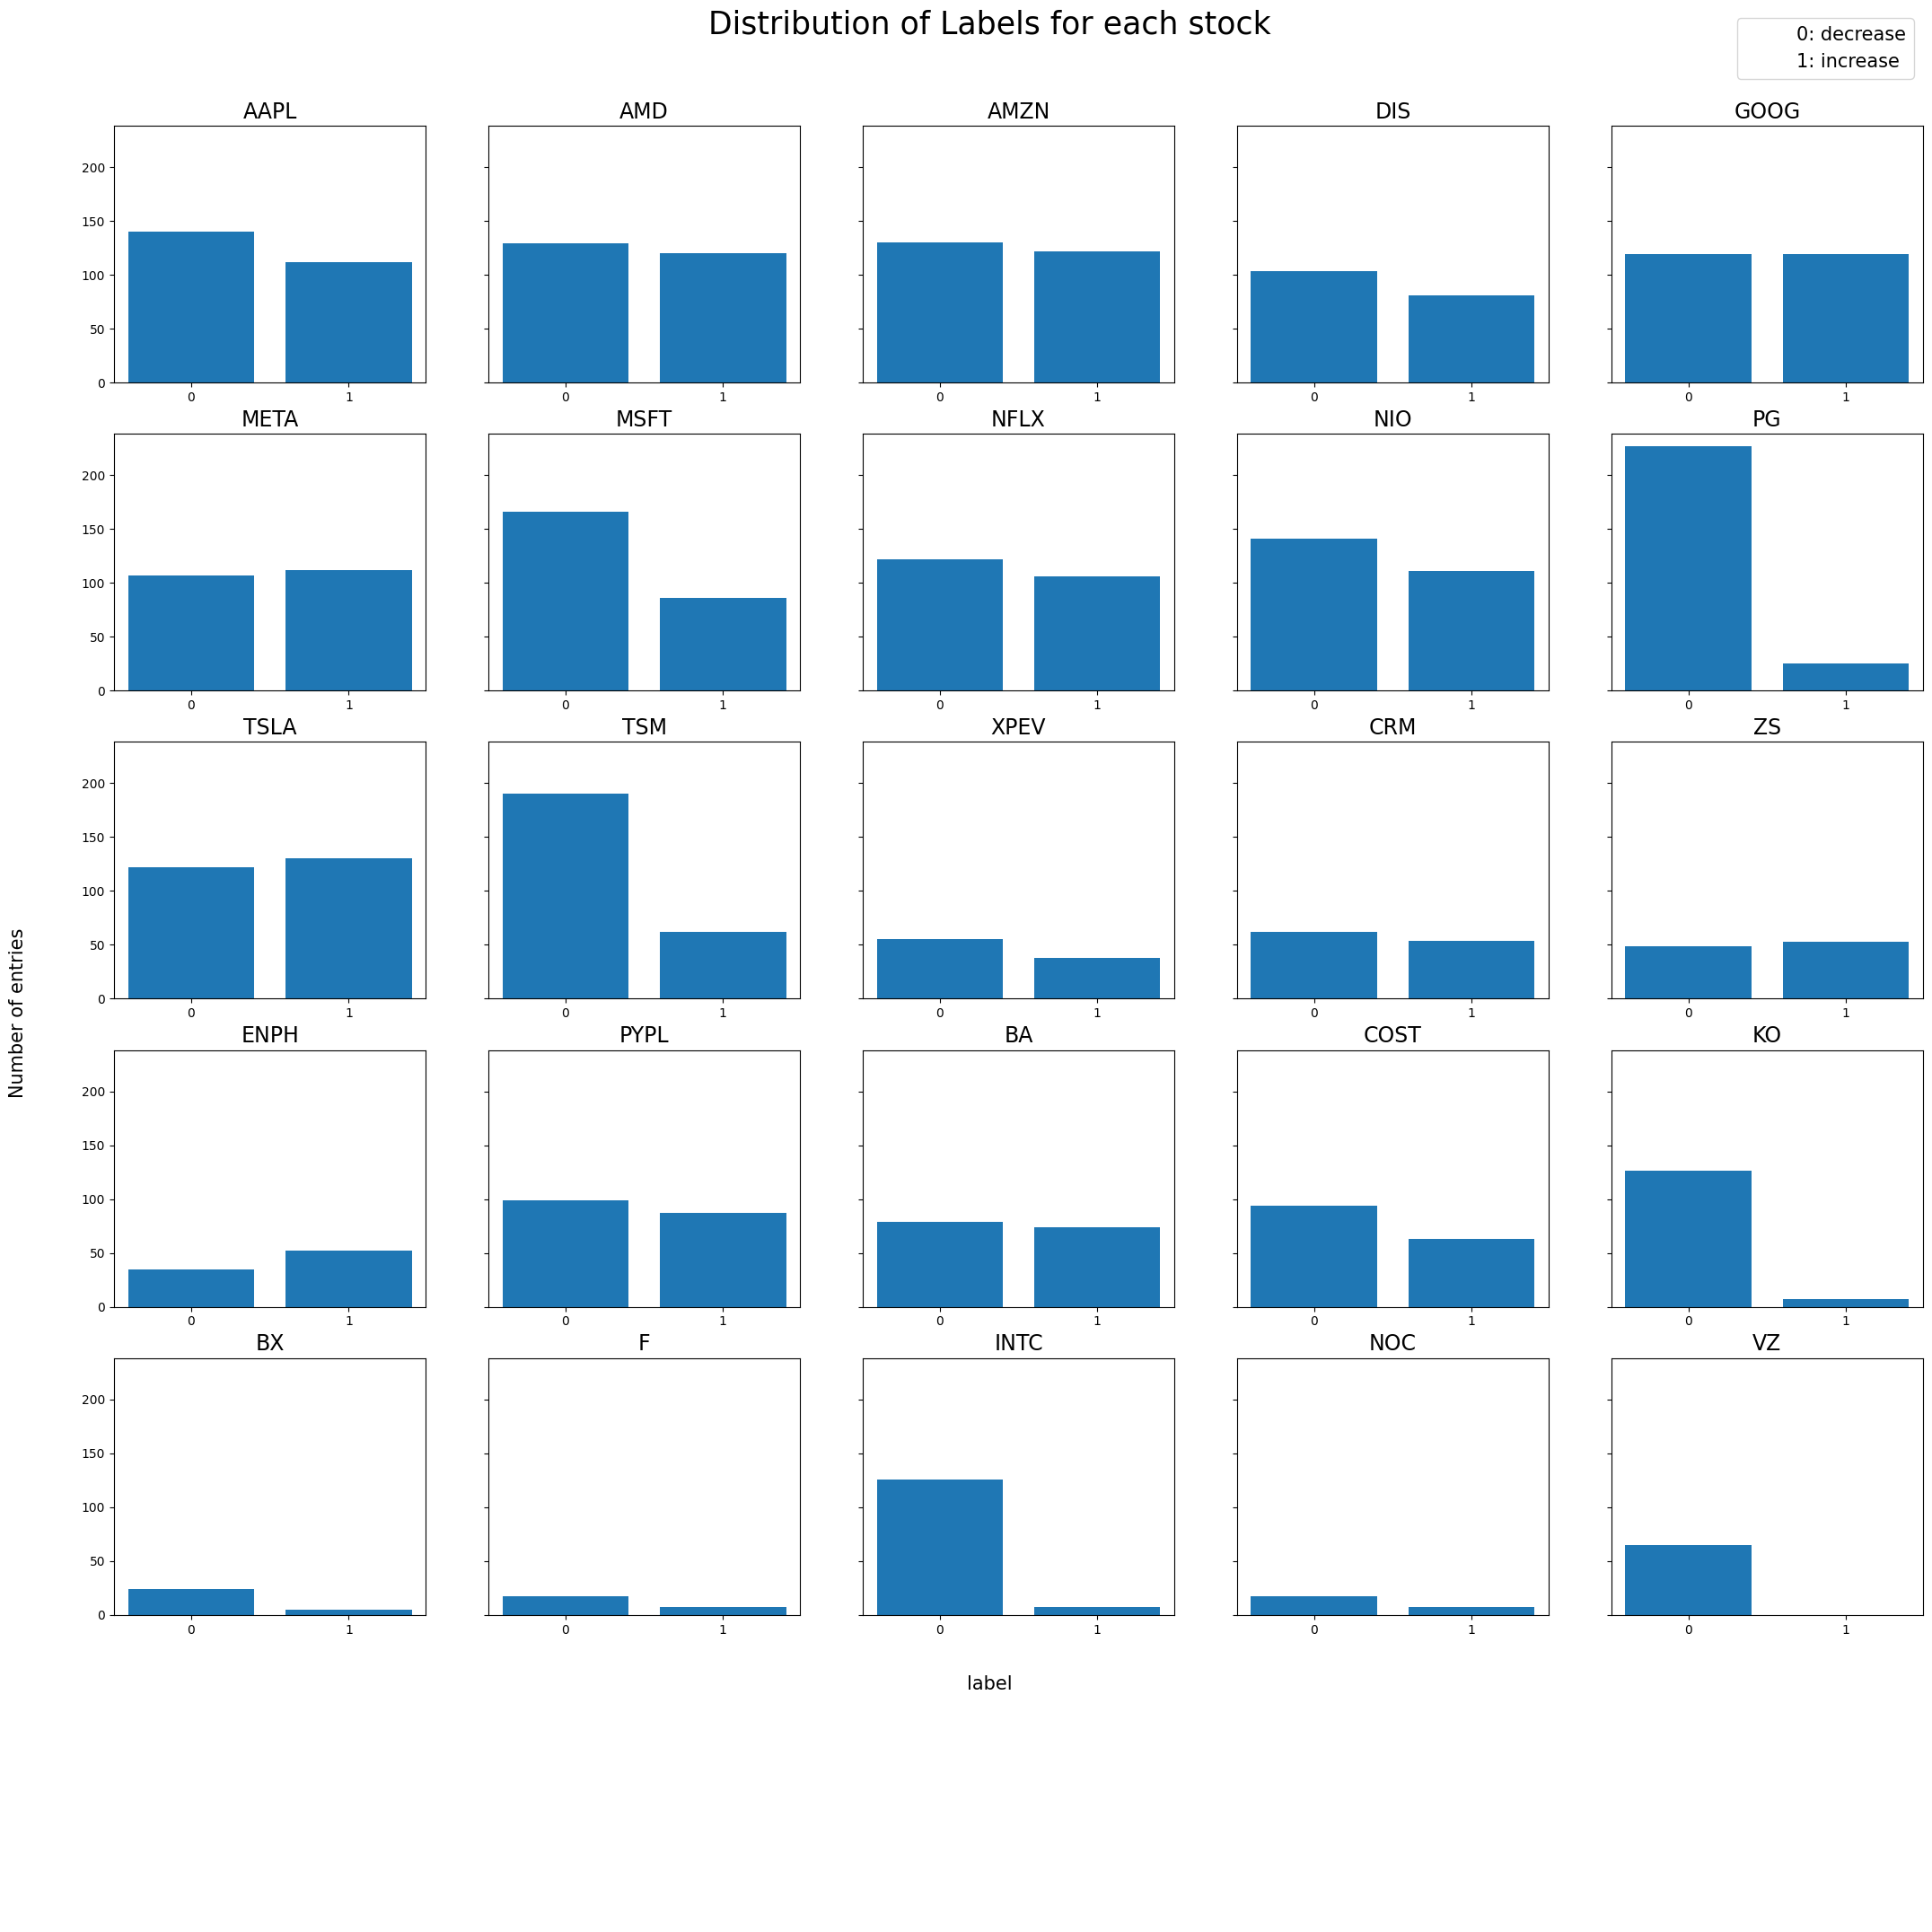

In [282]:
plot_multiple_distributions(
    df, 'Distribution of Labels for each stock', labels, x_label='label', y_label='Number of entries'
)

In [154]:
print("VZ distribution:")
vz_df = df[df['stock'] == 'VZ']
print(f"Label 0 count: {len(vz_df[vz_df['label'] == 0])}")
print(f"Label 1 count: {len(vz_df[vz_df['label'] == 1])}")

VZ distribution:
Label 0 count: 65
Label 1 count: 0


### 2.2.2. Dataset Split

#### **All stocks**

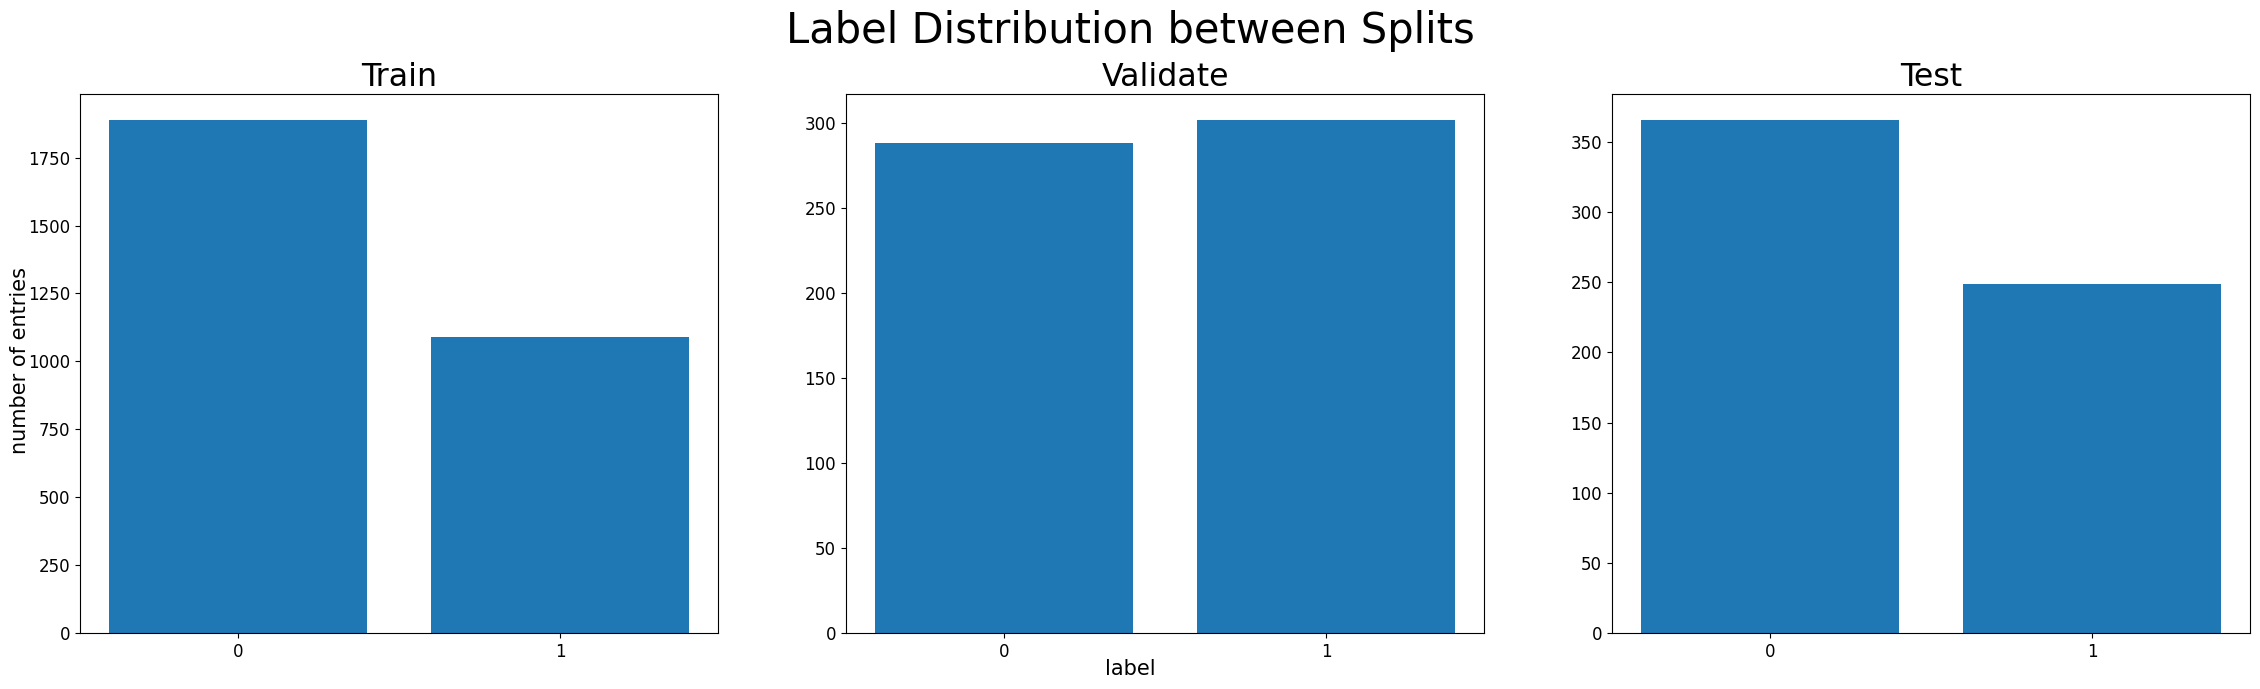

In [295]:
plot_multiple_dfs(
    [train_df, val_df, test_df], 'Label Distribution between Splits', ['Train', 'Validate', 'Test'], labels,
    x_col='label', x_label='label', y_label='number of entries', sharey=False, font_factor=1.2
)

## 2.3. Field Analysis
Discuss about the process of the datasets obtaining the specific stock name from a given Tweet.
Is it trustworthy? The Stock Finance data is trustworthy since it is crawled directly from a trusted source. But the means to which the stock name was obtained must be carefully inspected.

# 3. Enhanced Dataset
This is our finalized enhanced dataset creation functions. These will be included in `dataset.py` and can be called by every model notebook to retrieve this finalized dataset.

## 3.1. NLTK Setup

In [303]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

def download_nltk_resources():
    resources = ['punkt', 'wordnet', 'averaged_perceptron_tagger', 'sentiwordnet', 'omw-1.4']
    for resource in resources:
        try:
            print(f"Downloading NLTK resource: {resource}")
            nltk.download(resource, quiet=False)
        except Exception as e:
            print(f"Error downloading {resource}: {e}")
    print("NLTK resource download complete")

download_nltk_resources()

Error downloading punkt: name 'nltk' is not defined
Error downloading wordnet: name 'nltk' is not defined
Error downloading averaged_perceptron_tagger: name 'nltk' is not defined
Error downloading sentiwordnet: name 'nltk' is not defined
Error downloading omw-1.4: name 'nltk' is not defined
NLTK resource download complete


## 3.2. WordNet
We will be using WordNet as our form of word embedding.

In [304]:
def simple_pos_tag(tokens):
    """
    A basic POS tagger that assigns tags based on rules.
    """
    tagged = []
    for token in tokens:
        tag = 'NN'
        if token.endswith('ly'):
            tag = 'RB'
        elif token.endswith('ing'):
            tag = 'VBG'
        elif token.endswith('ed'):
            tag = 'VBD'
        elif token.endswith('s') and not token.endswith('ss'):
            tag = 'NNS'

        common_verbs = [
            'is', 'are', 'was', 'were', 'be', 'being', 'been', 'have', 'has', 'had',
            'do', 'does', 'did', 'go', 'goes', 'went', 'gone', 'see', 'saw', 'seen'
        ]
        if token.lower() in common_verbs:
            tag = 'VB'

        common_adj = [
            'good', 'bad', 'great', 'best', 'better', 'worst', 'worst', 'high',
            'low', 'big', 'small', 'large', 'little', 'many', 'much'
        ]
        if token.lower() in common_adj:
            tag = 'JJ'
        tagged.append((token, tag))
    return tagged


def enhance_text_with_wordnet(text):
    """
    Enhance text with WordNet features including synonyms and sentiment scores.
    Fully robust implementation that doesn't rely on NLTK's POS tagger.
    """
    try:
        if not isinstance(text, str):
            text = str(text) if text is not None else ""

        # simple robust tokenization
        simple_tokens = []
        for word in text.split():
            # handle common punctuation at the end of words
            if word and word[-1] in '.,:;!?)"\'':
                simple_tokens.append(word[:-1])
                simple_tokens.append(word[-1])
            # handle common punctuation at the start of words
            elif word and word[0] in '(\'\"':
                simple_tokens.append(word[0])
                simple_tokens.append(word[1:])
            else:
                simple_tokens.append(word)

        # remove empty tokens
        tokens = [token for token in simple_tokens if token]

        # use simple POS tagger instead of NLTK's
        try:
            tagged_tokens = simple_pos_tag(tokens)
        except Exception as pos_err:
            print(f"POS tagging error: {pos_err}")
            # fall back to just using tokens without enhancement
            return text

        # map simple POS tags to WordNet POS tags
        def get_wordnet_pos(tag):
            if tag.startswith('J'):
                return wn.ADJ
            elif tag.startswith('V'):
                return wn.VERB
            elif tag.startswith('N'):
                return wn.NOUN
            elif tag.startswith('R'):
                return wn.ADV
            else:
                return None

        enhanced_tokens = []
        for token, pos in tagged_tokens:
            # skip very short tokens, punctuations, and non-alphanumeric
            if len(token) <= 2 or not any(c.isalnum() for c in token):
                enhanced_tokens.append(token)
                continue

            # get WordNet POS
            wordnet_pos = get_wordnet_pos(pos)
            if not wordnet_pos:
                enhanced_tokens.append(token)
                continue

            # try to get synsets - robust error handling
            try:
                synsets = wn.synsets(token, pos=wordnet_pos)
            except Exception as wn_err:
                # just keep the original token if we can't get synsets
                enhanced_tokens.append(token)
                continue
            if not synsets:
                enhanced_tokens.append(token)
                continue

            # get the most common synset
            synset = synsets[0]

            # try to get SentiWordNet sentiment scores
            try:
                swn_synset = swn.senti_synset(synset.name())
                pos_score = swn_synset.pos_score()
                neg_score = swn_synset.neg_score()

                # add sentiment markers for strongly positive or negative words
                if pos_score > 0.6:
                    enhanced_tokens.append(f"{token}_POS")
                elif neg_score > 0.6:
                    enhanced_tokens.append(f"{token}_NEG")
                else:
                    enhanced_tokens.append(token)

                # add most common synonym for enrichment, but only for important words
                # to avoid too much noise
                if (wordnet_pos in [wn.NOUN, wn.VERB, wn.ADJ] and
                    len(synsets) > 1 and
                    len(synset.lemma_names()) > 1):
                    # avoid multi-word synonyms
                    synonyms = [
                        lemma for lemma in synset.lemma_names()
                        if lemma != token and '_' not in lemma
                    ]
                    if synonyms:
                        # take the first synonym and add it to the text
                        enhanced_tokens.append(synonyms[0])
            except Exception as swn_err:
                enhanced_tokens.append(token)

        return ' '.join(enhanced_tokens)
    except Exception as e:
        print(f"Error in WordNet enhancement: {e}")
        # return original text if enhancement fails
        return text if isinstance(text, str) else str(text)

## 3.3. Finalized Enhanced Dataset
This is our finalized enhanced dataset creation functions.

In [307]:
class EnhancedDataset(Dataset):
    def __init__(
        self, texts, dates, labels, stock_names, tokenizer, max_chunk_length=256, max_chunks=8, use_wordnet=True
    ):
        self.texts = texts
        self.dates = dates
        self.labels = labels
        self.stock_names = stock_names
        self.tokenizer = tokenizer
        self.max_chunk_length = max_chunk_length
        self.max_chunks = max_chunks
        self.use_wordnet = use_wordnet

        # encode stock names to indices
        self.stock_to_idx = {name: idx for idx, name in enumerate(sorted(set(stock_names)))}
        self.stock_indices = [self.stock_to_idx[name] for name in self.stock_names]

        # normalize time
        self.min_date = min(self.dates)
        self.time_values = [
            (pd.Timestamp(d).to_pydatetime() - pd.Timestamp(self.min_date).to_pydatetime()).days for d in self.dates
        ]
        max_days = max(self.time_values) if self.time_values else 0
        self.time_values = [days / max_days for days in self.time_values] if max_days > 0 else [0] * len(self.time_values)

        # enhance text
        self.enhanced_texts = [enhance_text_with_wordnet(str(t)) if use_wordnet else str(t) for t in self.texts]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.enhanced_texts[idx]
        time_value = self.time_values[idx]
        label = self.labels[idx]
        stock_idx = self.stock_indices[idx]

        words = text.split()
        chunks = [
            ' '.join(words[i:i+self.max_chunk_length//2]) for i in range(0, len(words), self.max_chunk_length//2)
        ][:self.max_chunks]
        tokenized = [
            self.tokenizer(
                chunk, add_special_tokens=True, max_length=self.max_chunk_length, padding='max_length',
                truncation=True, return_tensors='pt'
            ) for chunk in chunks
        ]
        if not tokenized:
            tokenized = [
                self.tokenizer(
                    '', add_special_tokens=True, max_length=self.max_chunk_length, padding='max_length',
                    truncation=True, return_tensors='pt'
                )
            ]

        input_ids = torch.stack([t['input_ids'].squeeze(0) for t in tokenized])
        attention_mask = torch.stack([t['attention_mask'].squeeze(0) for t in tokenized])

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'time_value': torch.tensor(time_value, dtype=torch.float),
            'stock_idx': torch.tensor(stock_idx, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }